### ANÁLISIS DE SERIES DE TIEMPO (VARIACIÓN DE VALOR DE DIFERENTES MONEDAS)

Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.



* Desarrollar un modelo ARMA que permita predecir el precio de las monedas en días futuros (forecasting). 

* Desarrollar un modelo de clasificación para determinar regímenes de mercado.  

## 1. Lectura del Dataframe 

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import os
import math 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')
from pmdarima import auto_arima  
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt 

In [4]:
datos = pd.read_csv(r'AUD_USD_H1.csv',index_col= 'time')
print(f'El dataframe que se construye con las variaciones de cotización de moneda está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

datos.head(5)

El dataframe que se construye con las variaciones de cotización de moneda está compuesto por 8 columnas y 50000 filas


,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [5]:
datos.shape

(50000, 8)

* Descripción del Dataframe.

* time: Hora en de apertura para cada periodo.

open_bid : Precio de apertura para la venta  a la hora indicada. 

high_bid : Precio más alto de venta del usuario para esa hora. 

low_bid : Precio más bajo de venta del usuario para esa hora.

close_bid: Precio de cierre para la venta a la hora indicada.

open_ask : Precio de apertura para la compra a la hora indicada. 

high_ask : Precio más alto de compra para el usuario para esa hora. 

low_ask : Precio más bajo de compra para usuario para esa hora.

close_ask : Precio de cierre para la compra a la hora indicada.

In [4]:
# Lista de todos los .csv de datos 
path = os.getcwd() 
files = [os.path.join(path, file) for file in os.listdir(path) if '.csv' in file]

# Generación de DataFrame
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# Colocar columna time como índice del DataFrame
df.index = df.time

# Eliminar columna y definición de DataFrame a utilizar
datos = df.drop(['time'], axis = 1)
datos.head()

,open_bid,high_bid,low_bid,close_bid,open_ask,high_ask,low_ask,close_ask
time,,,,,,,,
2015-01-27 08 PM,0.79375,0.79524,0.79347,0.79383,0.79393,0.79549,0.79366,0.79405
2015-01-27 09 PM,0.79382,0.79382,0.79265,0.79344,0.79405,0.79405,0.79287,0.79402
2015-01-27 10 PM,0.79338,0.79364,0.79243,0.79250,0.79385,0.79413,0.79283,0.79283
2015-01-27 11 PM,0.79256,0.79304,0.79184,0.79197,0.79290,0.79333,0.79204,0.79219
2015-01-28,0.79197,0.80024,0.78991,0.79930,0.79216,0.80055,0.79017,0.79952


In [6]:
datos.shape

(50000, 8)

* Calcular con todas las monedas el retorno (precio actual - precio del pasado), y luego de ello construir una regresión lineal buscando discernir si el retorno de varias monedas (features) logra explicar el retorno de una combinación de moneda (target)

## Construcción modelo ARIMA

# Variación Dolar Euro

In [15]:
datos = pd.read_csv(r'EUR_USD_H1.csv', parse_dates=['time'])
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

#print(datos_euro_dolar.head())

datos_a = datos[['open_bid','time']]
datos_a.head()


El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por 9 columnas y 50000 filas


,open_bid,time
0,1.13343,2015-01-28 02:00:00
1,1.13335,2015-01-28 03:00:00
2,1.13399,2015-01-28 04:00:00
3,1.13358,2015-01-28 05:00:00
4,1.13544,2015-01-28 06:00:00


In [16]:
datos_a['time'] = pd.to_datetime(datos_a['time'])
datos_ARIMA = datos_a.set_index("time")
datos_ARIMA.head()

C:\Users\mpire\AppData\Local\Temp\ipykernel_21724\90717955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_a['time'] = pd.to_datetime(datos_a['time'])


,open_bid
time,
2015-01-28 02:00:00,1.13343
2015-01-28 03:00:00,1.13335
2015-01-28 04:00:00,1.13399
2015-01-28 05:00:00,1.13358
2015-01-28 06:00:00,1.13544


In [19]:
# Resample del DataFrame , calculando open_bid promedio por día. 

df = datos_ARIMA.resample('D').agg({'open_bid':'mean'})
df

,open_bid
time,
2015-01-28,1.133460
2015-01-29,1.130125
2015-01-30,1.131697
2015-01-31,NaN
2015-02-01,1.130895
...,...
2023-02-06,1.076015
2023-02-07,1.072053
2023-02-08,1.073121


In [20]:
df["timeIndex"] = pd.Series(np.arange(len(df['open_bid'])), index=df.index)
df['log_value'] = np.log(df['open_bid'])

df['month'] = [d.strftime('%b') for d in df.index]
dummies_mes = pd.get_dummies(df['month'])
df = df.join(dummies_mes)

In [21]:
df.head(3)

,open_bid,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
time,,,,,,,,,,,,,,,,
2015-01-28,1.133460,0,0.125275,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-01-29,1.130125,1,0.122328,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-01-30,1.131697,2,0.123719,Jan,0,0,0,0,1,0,0,0,0,0,0,0


In [22]:
df.shape

(2936, 16)

In [26]:
# Para saber si existen valores nulos
df.isnull().sum()
# Eliminar valores nulos 
df.dropna(inplace=True)

In [108]:
df.head()

,open_bid,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
time,,,,,,,,,,,,,,,,
2015-01-28,1.133460,0,0.125275,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-01-29,1.130125,1,0.122328,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-01-30,1.131697,2,0.123719,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-02-01,1.130895,4,0.123009,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2015-02-02,1.132493,5,0.124422,Feb,0,0,0,1,0,0,0,0,0,0,0,0


In [28]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)

In [84]:
df_test.shape

(753, 19)

In [30]:
model_log_est = smf.ols('log_value ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [85]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [86]:
df_test.head()

,open_bid,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_model_log_est,log_model_ARIMA
time,,,,,,,,,,,,,,,,,,,
2020-09-11,1.183865,2053,0.168784,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146690,1.157995,NaN
2020-09-13,1.183790,2055,0.168721,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146717,1.158026,NaN
2020-09-14,1.185861,2056,0.170469,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146730,1.158041,NaN
2020-09-15,1.186879,2057,0.171327,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146744,1.158057,NaN
2020-09-16,1.183972,2058,0.168875,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146757,1.158072,NaN


In [32]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

In [ ]:
# Probamos primero si los residuos del modelo en la serie original son estacionarios

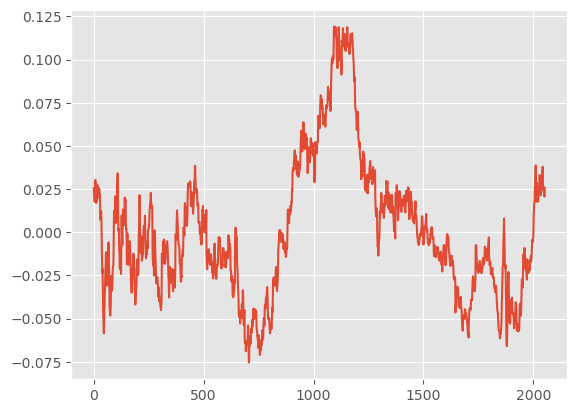

In [33]:
res_model = df_train['open_bid'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [34]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.815585
p-value: 0.056082
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


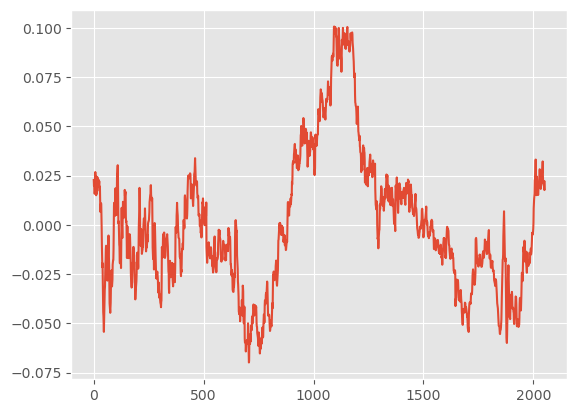

In [36]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [37]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.879122
p-value: 0.047830
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


Podemos rechazar la $H_0$. Avanzamos con el modelado de los ciclos de los residuos del modelo:

Calculamos la ACF para res_log con 20 rezagos:

In [46]:
lag_acf = acf(res_log_est, nlags = 750)
lag_acf

array([ 1.        ,  0.99344858,  0.98364852,  0.97379337,  0.96437067,
        0.95524802,  0.94638673,  0.93789871,  0.93018578,  0.92331074,
        0.91693529,  0.9106193 ,  0.90443227,  0.89858652,  0.89284779,
        0.88700681,  0.88170967,  0.87720103,  0.8732221 ,  0.86914811,
        0.86535209,  0.86176718,  0.85868163,  0.85602046,  0.85295951,
        0.84941739,  0.84599261,  0.84262536,  0.83858971,  0.83383939,
        0.82872458,  0.82347601,  0.8186171 ,  0.81385752,  0.80903833,
        0.80426109,  0.79950447,  0.794858  ,  0.78992584,  0.78535549,
        0.78094805,  0.77685614,  0.77303567,  0.7690959 ,  0.76499832,
        0.76077302,  0.75636664,  0.75136431,  0.74569662,  0.73953062,
        0.73308297,  0.72710806,  0.72151305,  0.71657568,  0.71225046,
        0.70839303,  0.70448815,  0.70074862,  0.69707732,  0.69365334,
        0.69034891,  0.68652499,  0.68231262,  0.67764264,  0.67254278,
        0.6673841 ,  0.6625215 ,  0.65795639,  0.65335468,  0.64

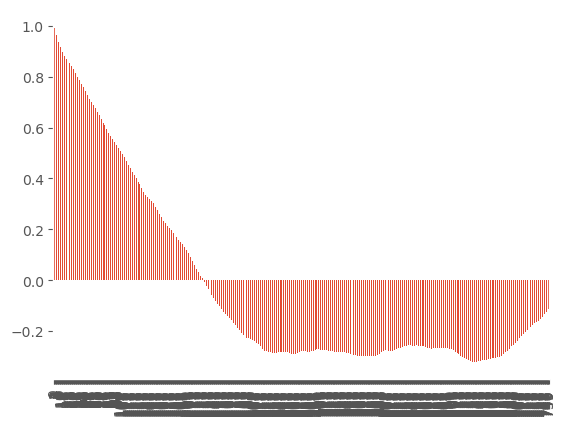

In [47]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

Calculamos la PACF para res_log con 20 rezagos. Usamos mínimos cuadrádos ordinarios para estimar los parámetros:

In [42]:
lag_pacf = pacf(res_log_est, nlags=20, method='ols');

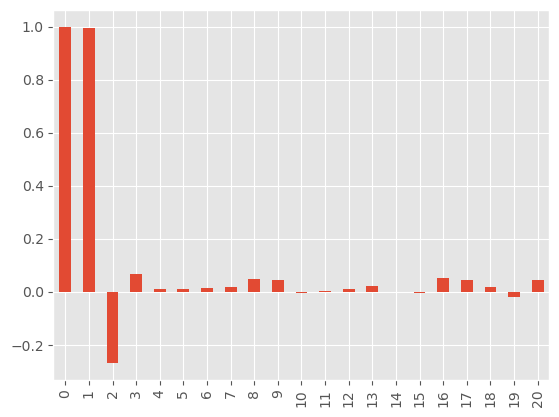

In [43]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [44]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


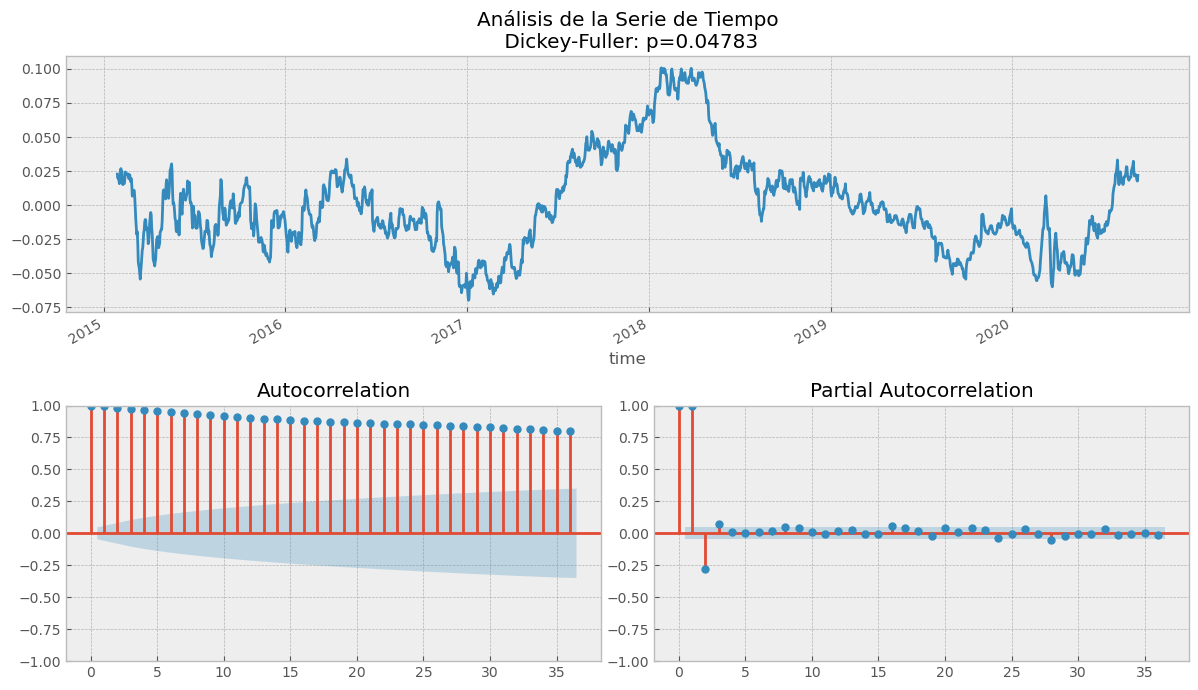

In [45]:
# Corremos la función con nuestra serie res_log:

tsplot(res_log_est, lags=36)

In [109]:
model_ARIMA = ARIMA(res_log_est, order=(100,1,3))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


time
2015-01-28    0.000000
2015-01-29    0.022805
2015-01-30    0.019152
2015-02-01    0.021779
2015-02-02    0.014413
dtype: float64

In [50]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1754
Model:                 ARIMA(3, 0, 3)   Log Likelihood                7287.257
Date:                Wed, 22 Mar 2023   AIC                         -14558.513
Time:                        21:02:20   BIC                         -14514.756
Sample:                             0   HQIC                        -14542.340
                               - 1754                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.013      0.164      0.870      -0.024       0.029
ar.L1         -0.1715      1.200     -0.143      0.886      -2.524       2.181
ar.L2          0.5130      0.748      0.686      0.4

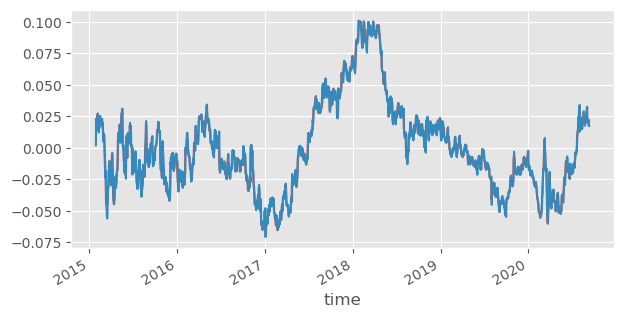

In [51]:
plt.figure(figsize=(7,3.5))
res_log_est.plot()
results_ARIMA.fittedvalues.plot();

In [53]:
res_ARIMA =  results_ARIMA.fittedvalues - res_log_est

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


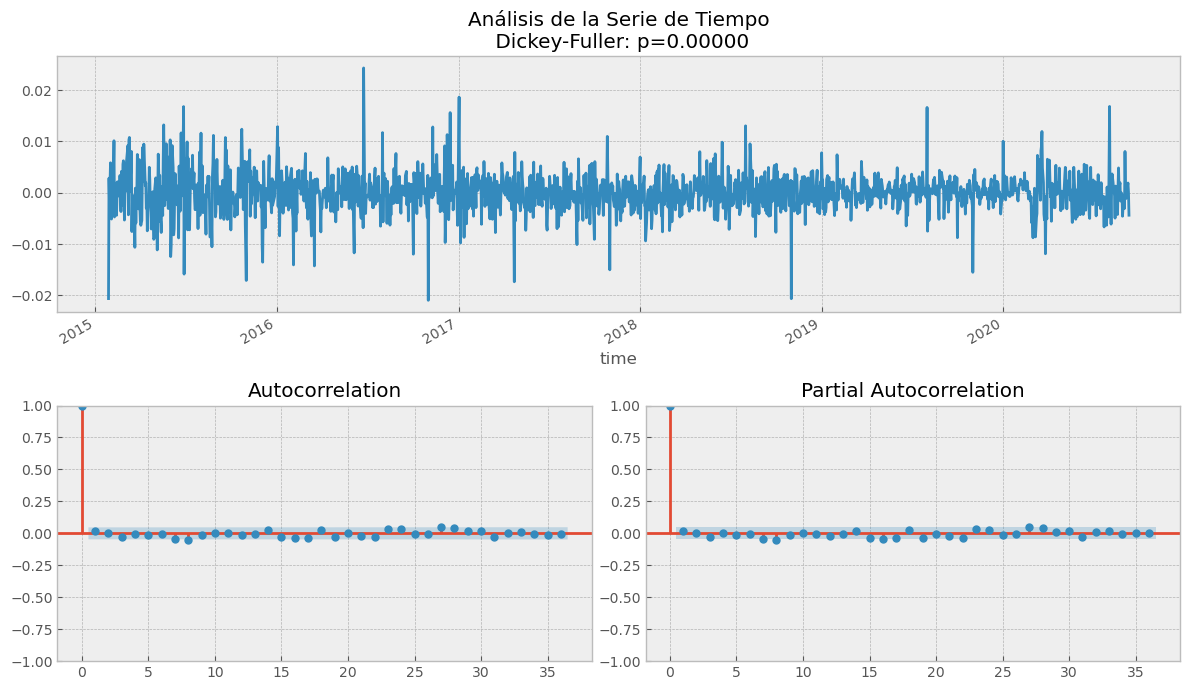

In [54]:
tsplot(res_ARIMA, lags=36)

In [57]:
df_test.head()

,open_bid,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_model_log_est
time,,,,,,,,,,,,,,,,,,
2020-09-11,1.183865,2053,0.168784,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146690,1.157995
2020-09-13,1.183790,2055,0.168721,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146717,1.158026
2020-09-14,1.185861,2056,0.170469,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146730,1.158041
2020-09-15,1.186879,2057,0.171327,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146744,1.158057
2020-09-16,1.183972,2058,0.168875,Sep,0,0,0,0,0,0,0,0,0,0,0,1,0.146757,1.158072


In [88]:
predictions_ARIMA = results_ARIMA.forecast(len(df_test['open_bid']), alpha=0.05)

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [87]:
predictions_ARIMA

1754    0.022842
1755    0.022713
1756    0.022533
1757    0.022330
1758    0.022191
          ...   
2502    0.002227
2503    0.002227
2504    0.002227
2505    0.002226
2506    0.002226
Name: predicted_mean, Length: 753, dtype: float64

In [93]:
predictions_ARIMA.index = df_test.index

In [94]:
predictions_ARIMA

time
2020-09-11    0.022842
2020-09-13    0.022713
2020-09-14    0.022533
2020-09-15    0.022330
2020-09-16    0.022191
                ...   
2023-02-06    0.002227
2023-02-07    0.002227
2023-02-08    0.002227
2023-02-09    0.002226
2023-02-10    0.002226
Name: predicted_mean, Length: 753, dtype: float64

In [92]:
results_ARIMA.fittedvalues.head()

time
2015-01-28    0.002195
2015-01-29    0.022687
2015-01-30    0.018993
2015-02-01    0.021624
2015-02-02    0.014164
dtype: float64

In [95]:
df_train['log_model_ARIMA'] = df_train['model_log_est'] + results_ARIMA.fittedvalues

df_test['log_model_ARIMA'] = df_test['model_log_est'] + predictions_ARIMA

In [96]:
df_test['log_model_ARIMA']

time
2020-09-11    0.169532
2020-09-13    0.169430
2020-09-14    0.169264
2020-09-15    0.169074
2020-09-16    0.168948
                ...   
2023-02-06    0.148728
2023-02-07    0.148742
2023-02-08    0.148755
2023-02-09    0.148768
2023-02-10    0.148781
Name: log_model_ARIMA, Length: 753, dtype: float64

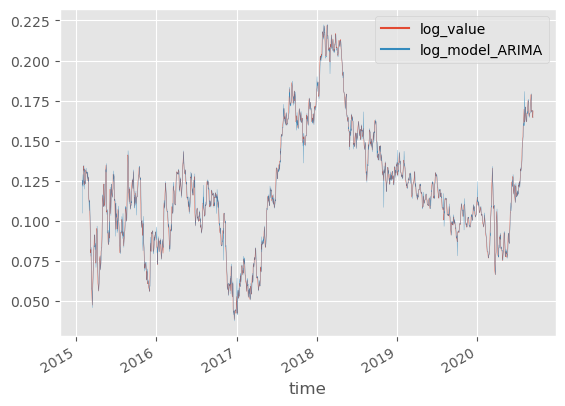

In [97]:
ax = df_train.plot(kind="line", y=['log_value', 'log_model_ARIMA'])
# Especificar el grosor de línea para la línea 'log_value'
ax.lines[0].set_linewidth(0.3)
ax.lines[1].set_linewidth(0.2)
# Mostrar el gráfico
plt.show()

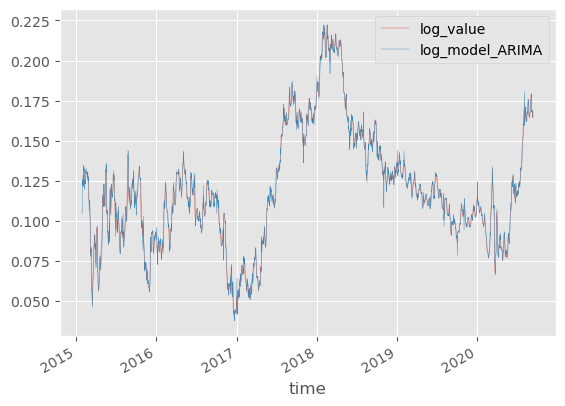

In [69]:
df_train.plot(kind = "line", y = ['log_value', 'log_model_ARIMA'], linewidth = 0.3);

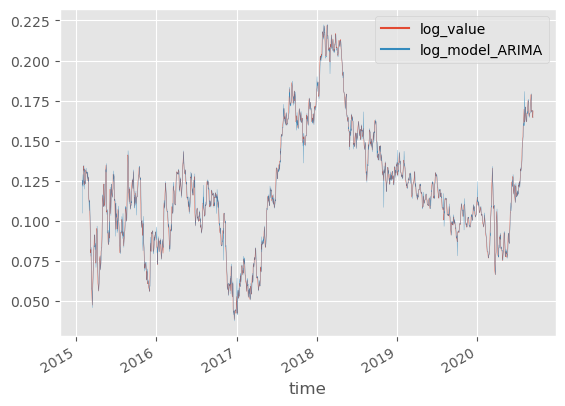

In [98]:
ax = df_train.plot(kind="line", y=['log_value', 'log_model_ARIMA'])
# Especificar el grosor de línea para la línea 'log_value'
ax.lines[0].set_linewidth(0.3)
ax.lines[1].set_linewidth(0.2)
# Mostrar el gráfico
plt.show()

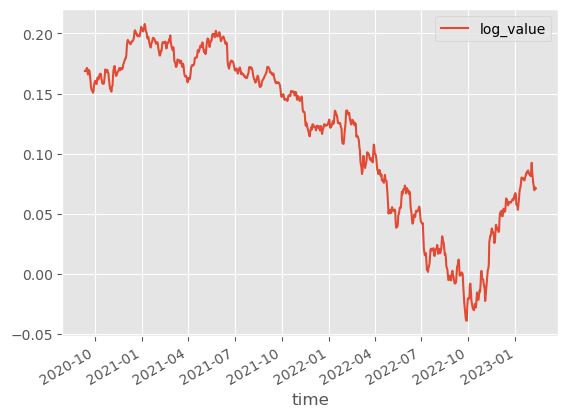

In [100]:
df_test.plot(kind = "line", y = ['log_value']);

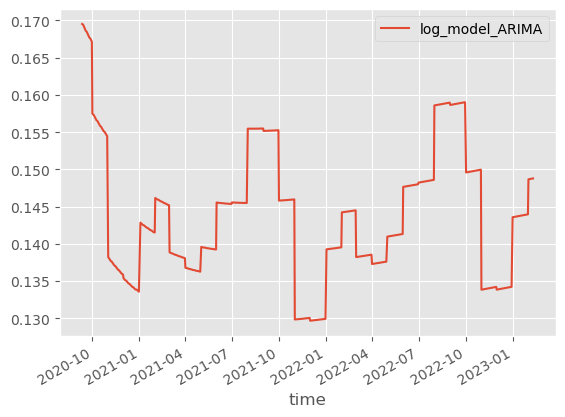

In [101]:
df_test.plot(kind = "line", y = ['log_model_ARIMA']);

Realizamos back-transformation al modelo logarítmico:

In [102]:
df_train['back_log_model_ARIMA'] = np.exp(df_train['log_model_ARIMA'])

df_test['back_log_model_ARIMA'] = np.exp(df_test['log_model_ARIMA'])

Ploteamos los resultados de la predicción con back-transformation en el set de train:

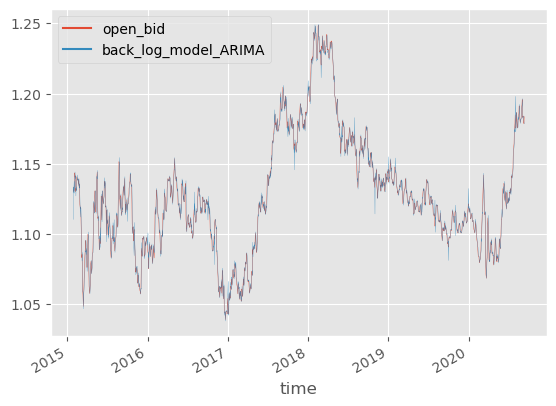

In [105]:
ax = df_train.plot(kind="line", y = ['open_bid', 'back_log_model_ARIMA'])
# Especificar el grosor de línea para la línea 'log_value'
ax.lines[0].set_linewidth(0.3)
ax.lines[1].set_linewidth(0.2)
# Mostrar el gráfico
plt.show()

Ploteamos los resultados de la predicción con back-transformation en el set de test:

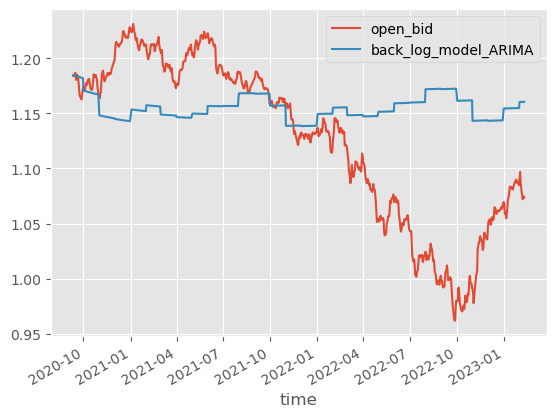

In [107]:
df_test.plot(kind = "line", y = ['open_bid', 'back_log_model_ARIMA']);